# Circular Spacelimitation and Spectral limitation

Simons and Wang section 5.3 (p 17)

In [50]:
using SpecialFunctions, FFTW, LinearAlgebra, Plots

In [145]:
N2D_fun(K, R = 1.0) = K^2*R^2/4

#=
# NB:
c = 2*sqrt(N2D)
gamma = sqrt(lambda/c)
phi = sqrt(zeta)*psi(zeta)
=#

# Roadmap:
# 1a. get the d_ls using eigenvector problem (78)
# 1b. get c
# 1c. Get the gammas, and finally the lambdas (79)
# 2. get the phi(zetas) (77)
# 3. rescale the phis to get the psis, which are g(r) (72)
# 4. rescale the zetas (65)
# 5. sub the g(r)s into g(r, theta, m), alpha indexes the g(r)'s.


""" Equation 78 """
function _get_dl(m, ell, c = 1)
    om1 = map(l -> - c^2 * (m + l + 1)^2 / ((2 * l + m + 1) * (2 * l + m + 2)), 0:(ell-1))
    d = map(l -> (2*l + m + 0.5)*(2* l + m + 1.5) + (c^2/2)*(1 + m^2/((2*l + m)*(2*l + m + 2))), 0:ell)
    o1 = map(l -> - c^2 * (l + 1)^2 / ((2 * l + m + 2) * (2 * l + m + 3)), 0:(ell-1))
    T = Array(Tridiagonal(om1, d, o1))
    return reverse(eigvals(T))
end

c = 13
N2D = (c/2)^2

""" Stirling's approximation to factorial """
function approxfact(n) 
    try 
        factorial(n)
    catch 
        exp(n * log(n) -n + log(2π*n)/2)
    end
end

""" Equation 79 """
function _get_conc(m, ell, c = 1)
    dl = _get_dl(m, ell, c)
    gamma = (c^(m + 0.5)*dl[1]/2^(m+1)*approxfact(m+1)).*(1.0./sum(dl, dims = 1))
    # lambda
    return gamma, c*gamma.^2
end

" Helper function to get phi(zeta) "
function _phi_arg(zeta, m::Int64, ell::Int64; gamma = 1, d_ell = ones(length(ell)), c = 1)
    return (d_ell *approxfact(ell)/approxfact(ell+m)) * besselj(m + 2*ell + 1, c*zeta)/sqrt(c*zeta)
end

""" 

    phi(zeta, m, ell, <kwargs>)

Evaluate equation 77

# Arguments
- `zeta::Float64`
- `m::Int64` number of cuts through the poles
- `ell::Int64` number of terms in the expansion (84 used in the paper, must use Stirling approximation to factorial)


"""
function phi_fun(zeta::T, m::Int64, ell = 10; gamma = 1.0, d_ell = ones(length(ell)), c = 1) where{T<:Number}
    zeta < 0 && error("zeta must be positive")
    zeta == 0.0 && return 0.0
    factorial(m)/gamma * sum(l -> _phi_arg(zeta, m, l, gamma = gamma, d_ell = d_ell, c = c), 0:ell)[1]
end

g(r, phi_vec, R = 1.0) = sqrt(r/R)*phi_vec

""" 
    g(r, theta, m)

Polar-coordinate 2D Cartesian Slepian where Eqn. (62) """ 
function g(r, theta, m)
    if m < 0
        return sqrt(2)*g(r)*cos(m*theta)
    elseif m == 0
        return g(r)
    else
        return sqrt(2)*g(r)*sin(m*theta)
    end
end

#=
""" Equation (60b) """
function kernfun(zeta, zeta1, N2D) 
    (zeta == zeta1) && return (sqrt(N2D)/(4*pi))
    return (sqrt(N2D)/(2*pi))*besselj1(sqrt(N2D), sqrt(sum(abs2, zeta .- zeta1)))/sqrt(sum(abs2, zeta .- zeta1))
end
=#

# approxfact(3), approxfact(40)

g

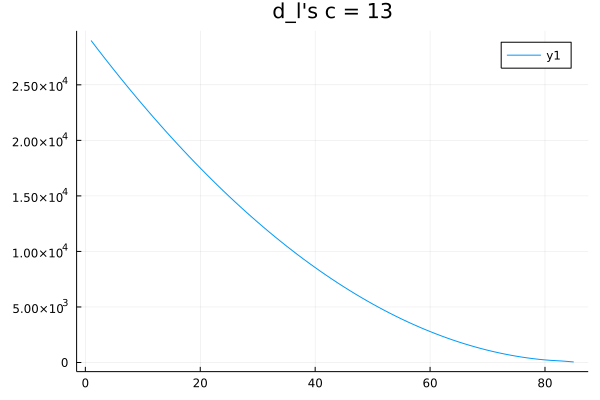

In [146]:
m = 1; ell = 84
T = _get_dl(m, ell, c)
plot(T, title = "d_l's c = 13")

In [127]:
lams, gams = _get_conc(m, ell, c)

lams

85×85 Array{Float64,2}:
  1.1094         1.34008        1.492         …   2.30936        2.45824
  5.26252        6.35675        7.07742          10.9546        11.6608
  7.59495        9.17417       10.2142           15.8099        16.8291
  5.69274        6.87643        7.65601          11.8502        12.6141
  2.66901        3.22398        3.58948           5.55589        5.91407
  0.861576       1.04072        1.15871       …   1.79348        1.90911
  0.203397       0.24569        0.273543          0.423397       0.450693
  0.0366348      0.0442522      0.0492691         0.07626        0.0811764
  0.0051969      0.0062775      0.00698917        0.010818       0.0115154
  0.000595288    0.000719066    0.000800586       0.00123917     0.00131906
  5.6182e-5      6.7864e-5      7.55577e-5    …   0.00011695     0.00012449
  4.44221e-6     5.36588e-6     5.97421e-6        9.24704e-6     9.84319e-6
  2.98423e-7     3.60474e-7     4.0134e-7         6.21205e-7     6.61254e-7
  ⋮          

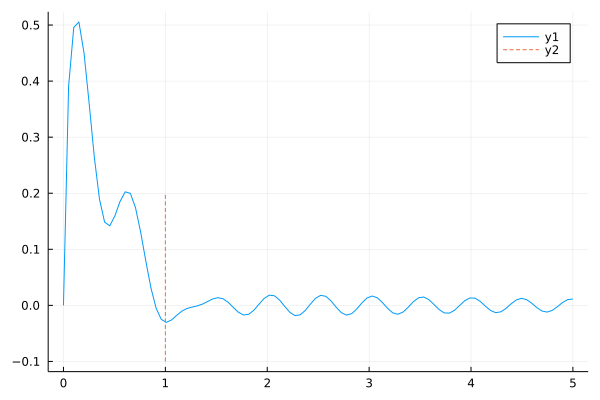

In [54]:
R = 1.0
r = LinRange(0, 5, 100)

zeta = r/R

m = 0
ell = 4
# phi_fun(zeta::T, m::Int64, ell = 10; gamma = 1.0, d_ell = ones(length(ell)), c = 1)
phi_eval = map(z -> phi_fun(z, m, ell, c = 13), zeta)

plot(zeta, phi_eval)
plot!(ones(2), [-0.1, 0.2], linestyle = :dash)

In [36]:
_phi_arg(0.0, 1, 0)

1-element Array{Float64,1}:
 NaN